In [38]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [39]:
train_df.count()

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

In [40]:
train_df2 = train_df.copy()
train_df2.count()

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

In [41]:
test_df2 = test_df.copy()
test_df2.count()

id          3263
keyword     3237
location    2158
text        3263
dtype: int64

In [42]:
train_df2.drop(['keyword', 'location'], axis=1, inplace=True)
train_df2.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [43]:
train_df2.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [44]:
print('Percentage of real: {0}%'.format(round(100 * train_df2['target'].sum() / len(train_df2['target']),2)))

Percentage of real: 42.97%


Text(0, 0.5, 'Real')

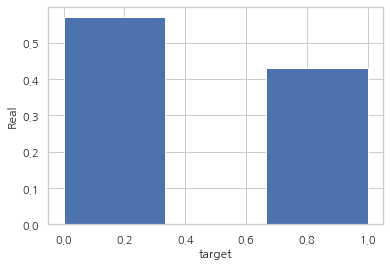

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

plt.hist(train_df2['target'], bins=3, weights=np.ones(len(train_df2['target'])) / len(train_df2['target']))
plt.xlabel('target')
plt.ylabel('Real')

In [46]:
real = train_df2['text'].iloc[(train_df2['target'] == 1).values]
fake = train_df2['text'].iloc[(train_df2['target'] == 0).values]
print(real[:10])
print(fake[:10])

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object
15                  What's up man?
16                   I love fruits
17                Summer is lovely
18               My car is so fast
19    What a goooooooaaaaaal!!!!!!
20          this is ridiculous....
21               London is cool ;)
22                     Love skiing
23           What a wonderful day!
24                        LOOOOOOL
Name: text, dtype: object


In [47]:
# message length
train_df2['text_length'] = train_df2['text'].apply(lambda text : len(text))
train_df2.head()

,id,text,target,text_length
0,1,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,Forest fire near La Ronge Sask. Canada,1,38
2,5,All residents asked to 'shelter in place' are ...,1,133
3,6,"13,000 people receive #wildfires evacuation or...",1,65
4,7,Just got sent this photo from Ruby #Alaska as ...,1,88


Text(0.5, 1.0, 'text lengths')

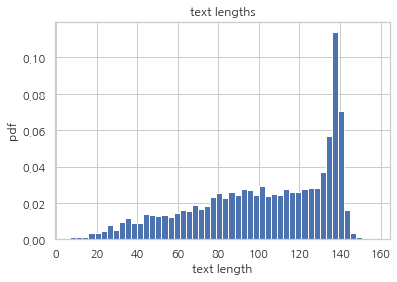

In [48]:
plt.hist(train_df2['text_length'], bins=50, weights=np.ones(len(train_df2))/ len(train_df2))
plt.xlabel('text length')
plt.ylabel('pdf')
plt.title('text lengths')

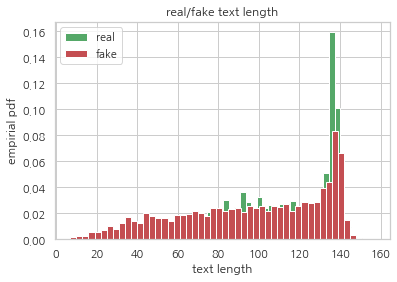

In [49]:
plt.hist(real.apply(lambda x : len(x)), 
        bins=50,
        weights=np.ones(len(real)) / len(real),
        facecolor='g',
        label='real')
plt.hist(fake.apply(lambda x : len(x)),
        bins=50,
        weights=np.ones(len(fake)) / len(fake),
        facecolor='r',
        label='fake')
plt.xlabel('text length')
plt.ylabel('empirial pdf')
plt.title('real/fake text length')
plt.legend()

In [50]:
import nltk

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

fake_tokens = []
for fake_iter in fake:
    fake_tokens += nltk.tokenize.word_tokenize(fake_iter)

real_tokens = []
for real_iter in real:
    real_tokens += nltk.tokenize.word_tokenize(real_iter)

print(fake_tokens[:10])
print(real_tokens[:10])

['What', "'s", 'up', 'man', '?', 'I', 'love', 'fruits', 'Summer', 'is']
['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', '#', 'earthquake', 'May']


In [51]:
# remove stop words and puncuation from tokens
stop_words = ['.', 'to', '!', ',', 'a', '&', 
              'or', 'the', '?', ':', 'is', 'for',
              'and', 'from', 'on', '...', 'in', ';',
              'that', 'of', '@', '#', '-']
for tokens in [fake_tokens, real_tokens]:
    for stop_word in stop_words:
        try:
            while True:
                tokens.remove(stop_word)
        except ValueError:
            pass

In [52]:
most_common_tokens_in_fakes = Counter(fake_tokens).most_common(20)
most_common_tokens_in_reals = Counter(real_tokens).most_common(20)
print(most_common_tokens_in_fakes)
print(most_common_tokens_in_reals)

[('http', 1927), ('I', 1242), ('you', 621), ("'s", 504), ('my', 443), ("'", 432), ('it', 423), ('with', 354), ("n't", 324), ('The', 298), ('https', 276), ('be', 271), ('this', 235), ('like', 235), ('have', 231), ('me', 230), (')', 229), ('by', 227), ('at', 216), ('was', 215)]
[('http', 2380), ('I', 329), ("'", 304), ('at', 275), ("'s", 272), ('The', 259), ('by', 245), ('it', 182), ('A', 172), ('was', 167), ('with', 163), ('are', 151), (')', 144), ('(', 142), ('after', 140), ('as', 139), ('have', 137), ('amp', 135), ('https', 133), ('fire', 127)]


In [53]:
data, test_data = train_test_split(train_df2, test_size=0.3)
print('Train-valid data length: {0}'.format(len(data)))
print('Test-valid data length: {0}'.format(len(test_data)))

Train-valid data length: 5329
Test-valid data length: 2284


In [54]:
binary_vectorizer = CountVectorizer(binary=True)
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [55]:
def feature_extraction(df, test=False):
    if not test:
        tfidf_vectorizer.fit(df['text'])
    
    X = np.array(tfidf_vectorizer.transform(df['text']).todense())
    return X

In [56]:
train_df, valid_df = train_test_split(data, test_size=0.3)

X_train = feature_extraction(train_df)
y_train = train_df['target']

X_valid = feature_extraction(valid_df, test=True)
y_valid = valid_df['target']

In [57]:
clfs = {
    'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    'svm1': SVC(kernel='linear'),
    'svm2': SVC(kernel='rbf'),
    'svm3': SVC(kernel='sigmoid'),
    'mlp1': MLPClassifier(),
    'mlp2': MLPClassifier(hidden_layer_sizes=[100, 100]),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression()
}

In [ ]:
f1_scores = dict()

for clf_name in clfs:
    print(clf_name)
    clf = clfs[clf_name]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    f1_scores[clf_name] = f1_score(y_pred, y_valid)




mnb
gnb
svm1
svm2
svm3
mlp1
mlp2
ada
dtc
rfc
gbc


In [22]:
f1_scores

{'mnb': 0.6906222611744084,
 'gnb': 0.6263871763255241,
 'svm1': 0.7307398932112891,
 'svm2': 0.7046379170056958,
 'svm3': 0.7335907335907336,
 'mlp1': 0.7058823529411764,
 'mlp2': 0.6957153231663036,
 'ada': 0.6244725738396625,
 'dtc': 0.6100443131462334,
 'rfc': 0.6655172413793105,
 'gbc': 0.6538139145012574,
 'lr': 0.7118110236220472}

In [23]:
clfs = {
    'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    'svm': SVC(kernel='linear'),
    'mlp': MLPClassifier(),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression()
}

In [ ]:
def feature_extraction(df, test=False):
    if not test:
        tfidf_vectorizer.fit(df['text'])
    
    X = np.array(tfidf_vectorizer.transform(df['text']).todense())
    return X

In [24]:
X_train = feature_extraction(train_df)
X_valid = feature_extraction(valid_df, test=True)

In [25]:
f1_scores = dict()

for clf_name in clfs:
    print(clf_name)
    clf = clfs[clf_name]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    f1_scores[clf_name] = f1_score(y_pred, y_valid)

mnb
gnb
svm
mlp
ada
dtc
rfc
gbc
lr


In [26]:
f1_scores

{'mnb': 0.6906222611744084,
 'gnb': 0.6263871763255241,
 'svm': 0.7307398932112891,
 'mlp': 0.70345842531273,
 'ada': 0.6244725738396625,
 'dtc': 0.6045824094604583,
 'rfc': 0.6516072980017376,
 'gbc': 0.6515912897822446,
 'lr': 0.7118110236220472}

In [27]:
clf = BernoulliNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
f1_score(y_pred, y_valid)

0.7014542343883661

In [28]:
def feature_extraction(df, test=False):
    if not test:
        count_vectorizer.fit(df['text'])
    
    X = np.array(count_vectorizer.transform(df['text']).todense())
    X = np.concatenate((X, df['text_length'].values.reshape(-1, 1)), axis=1)
    return X

In [29]:
X_train = feature_extraction(train_df)
X_valid = feature_extraction(valid_df, test=True)

In [30]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
f1_score(y_pred, y_valid)

0.7215999999999999

In [32]:
alpha_values = [i * 0.1 for i in range(11)]
max_f1_score = float('-inf')
best_alpha = None
for alpha in alpha_values:
    clf = MultinomialNB(alpha=alpha)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    current_f1_score = f1_score(y_pred, y_valid)
    if current_f1_score > max_f1_score:
        max_f1_score = current_f1_score
        best_alpha = alpha

In [33]:
print('Best alpha: {0}'.format(best_alpha))
print('Best f1-score: {0}'.format(max_f1_score))

Best alpha: 0.4
Best f1-score: 0.7318952234206472


In [34]:
clf = MultinomialNB(alpha=0.4)

In [ ]:
X_train = feature_extraction(data)
y_train = data['target'].values

X_test = feature_extraction(test_data, test=True)
y_test = test_data['target'].values

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

example_train_vectors = tfidf.fit_transform(train_df["text"][0:5])


In [3]:
train_vectors = tfidf.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = tfidf.transform(test_df["text"])


In [13]:
clf = linear_model.RidgeClassifier()
  
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores


array([0.63366337, 0.6122449 , 0.68442211])

In [5]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

# Calculation F1 Score

In [29]:
import numpy as np
import sklearn.metrics as metrics

np.dtype(test_vectors)
test_vectors

<3263x21637 sparse matrix of type '<class 'numpy.float64'>'
	with 41511 stored elements in Compressed Sparse Row format>

In [1]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()
#train_df.info()
#train_df[train_df["target"] == 0]["text"].values[1]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [2]:

count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])

count_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [3]:
## we use .todense() here because these vectors are "spares" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


In [4]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test_df["text"])


In [5]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()

In [6]:

scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.59453669, 0.56455572, 0.64082434])

In [7]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [8]:
sample_submission = pd.read_csv("sample_submission.csv")

In [9]:
sample_submission["target"] = clf.predict(test_vectors)

In [10]:
sample_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [11]:
sample_submission.to_csv("submission.csv", index=False)